## Swin Transformer 

3d 뇌 이미지에서 종양을 Segmentation합니다. Swin UNETR 모델을 사용하며 Dataset은 BraTS 21 Challenge를 사용합니다.  

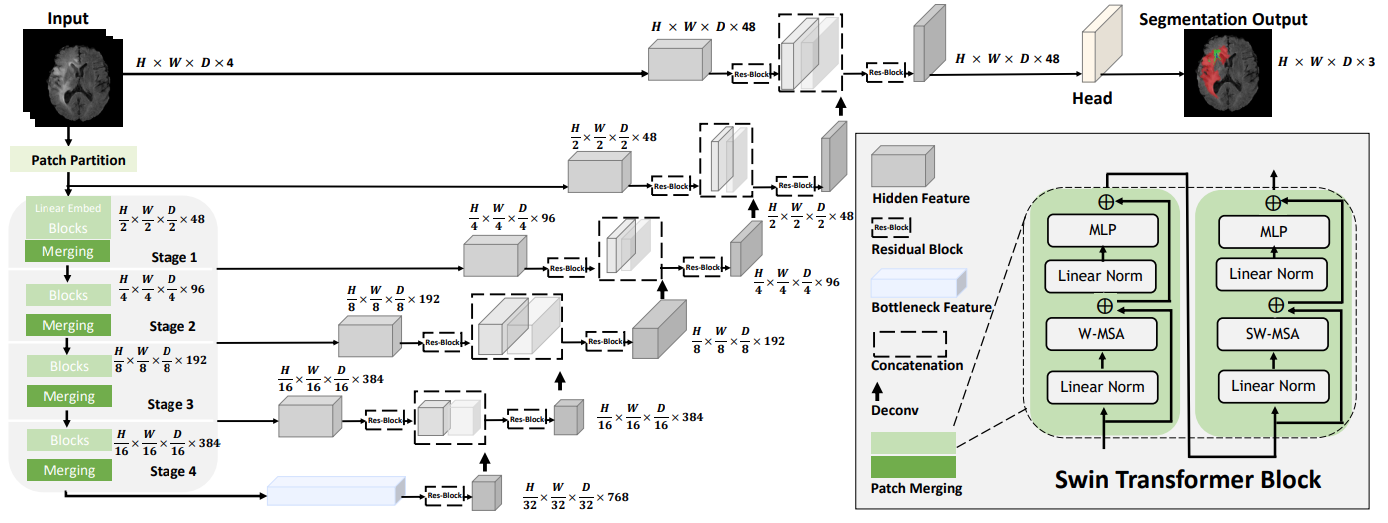

이 MONAI 튜토리얼에는 다음 기능이 포함되어 있습니다.

1. 딕셔너리 데이터를 변환합니다.
2. MONAI 변환 API에 따라 새로운 변환을 정의합니다.
3. 메타데이터와 함께 Nifti 이미지를 로드하고 이미지 목록을 로드하고 쌓습니다.
4. 데이터 확대를 위해 각 축에서 무작위로 회전합니다.
5. 데이터 확대를 위해 강도를 무작위로 조정합니다.
6. 교육 및 검증을 가속화하기 위해 IO 및 변환을 캐시합니다.
7. Swin UNETR 모델, Dice 손실 함수, 뇌종양 세분화 작업을 위한 Mean Dice 메트릭.

## Tumor Characteristics 

BraTS 21 챌린지에서 평가를 위해 고려하는 항목은 다음과 같습니다. 
강화종양(ET), 종양코어(TC) 및 전체종양(WT)입니다. 

ET는 T1과 비교할 때 T1Gd에서 고강도를 나타내는 영역으로 설명되지만 T1Gd의 "건강한" white matter과 비교할 때도 마찬가지입니다. 

TC는 일반적으로 절제되는 종양의 대부분을 설명합니다. TC는 종양의 괴사(NCR) 부분뿐만 아니라 ET를 수반합니다. 

NCR의 출현은 일반적으로 T1과 비교할 때 T1-Gd에서 저강도입니다. WT는 질병의 완전한 범위를 설명하는데, 이는 TC 및 일반적으로 고강도 신호로 묘사되는 종양 주위의 부종성/침습 조직(ED)을 수반하기 때문입니다. 

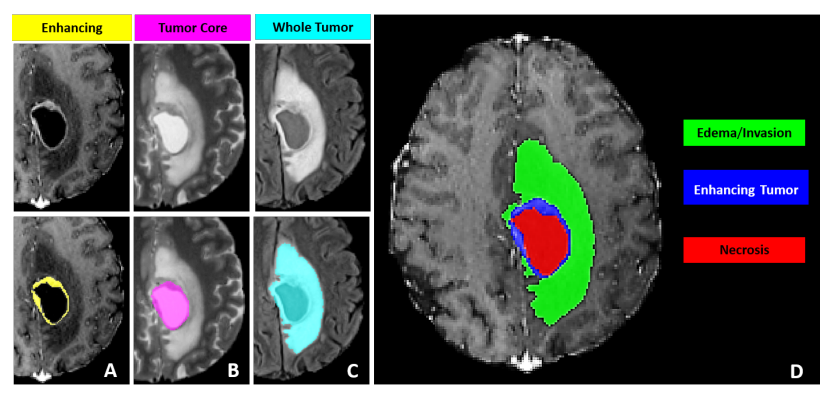

## Swin UNETR Model

Swin UNETR에 대한 입력은 4채널의 3D 멀티-모달 MRI 이미지입니다. 
Patch Partition block은 input data의 겹치지 않는 patch를 생성하고 이를 128x128x128 해상도의 임베딩 토큰에 투영합니다. 

그런 다음 projection 된 token은 로컬 window 내에서 self-attention이 계산되는 3D Swin Transformer를 사용하여 인코딩됩니다. 서로 다른 window 간의 상호 작용은 아래 그림과 같이 3D window 이동을 사용하여 얻을 수 있습니다.

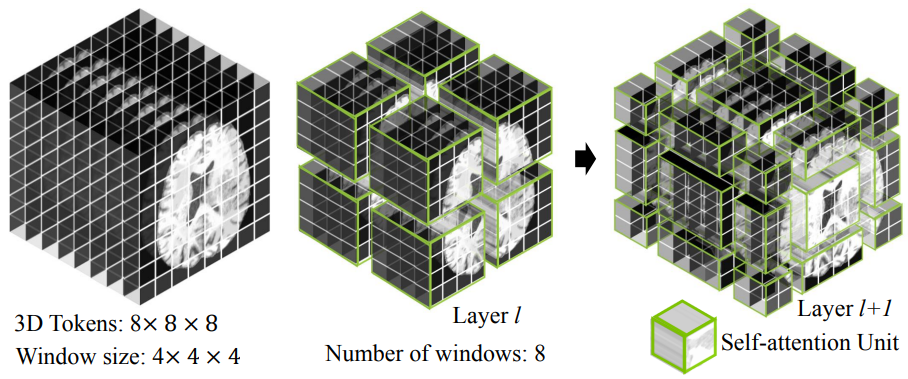

Transformer 기반 인코더는 여러 해상도에서 Skip connection을 통해 CNN 디코더에 연결됩니다. Segmentation output은 ET,WT 그리고 TC 하위 부분 3개의 출력 채널로 이루어져있습니다.

1x1x1 컨볼루션 레이어와 Sigmoid 활성화 함수를 사용하여 계산합니다.

## Code

In [2]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [3]:
import os
import json
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data
from monai.data import decollate_batch
from functools import partial

import torch


print_config()

MONAI version: 1.2.0
Numpy version: 1.23.5
Pytorch version: 2.0.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /home/minyoungxi/anaconda3/envs/TorchEnv/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.12
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: 0.21.0
Pillow version: 8.4.0
Tensorboard version: 2.13.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.15.0
tqdm version: 4.65.0
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 2.0.3
einops version: 0.6.1
transformers version: 4.30.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp_v1tyfyk


## Setup Average meter , fold reader, checkpoint server

In [6]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.where(self.count > 0, self.sum / self.count, self.sum)


def datafold_read(datalist, basedir, fold=0, key="training"):
    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k in d:
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]

    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)

    return tr, val


def save_checkpoint(model, epoch, filename="model.pt", best_acc=0, dir_add=root_dir):
    state_dict = model.state_dict()
    save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict}
    filename = os.path.join(dir_add, filename)
    torch.save(save_dict, filename)
    print("Saving checkpoint", filename)

# Setup dataloader

* transforms 에서 ConvertToMultiChannelBasedOnBratsClassesd는 BraTS (Brain Tumor Segmentation Challenge) 데이터셋에 사용되는 변환 중 하나입니다. BraTS 데이터셋은 뇌 종양 분할을 위한 데이터셋으로, 여러 클래스의 뇌 종양을 포함하고 있습니다. 
    * 단일 채널의 레이블 이미지를 다중 채널의 바이너리 마스크 이미지로 변환
    * 각 채널은 BraTS 데이터셋의 특정 종양 클래스(예: 활성 종양, 경계 종양 등)에 대응합니다. 
    * 이 변환을 통해, 각 종양 클래스에 대한 분할 마스크를 별도의 채널로 분리하여 다중 클래스 분할 작업을 용이하게 합니다. 
    
* transforms.CropForegroundd 주어진 데이터에서 전경 (즉, 0이 아닌 값들)을 포함하는 영역을 자릅니다. 이는 의료 영상에서 종종 배경과 실제 관심 영역 (예: 종양, 기관 등)을 구분하기 위해 사용됩니다. 이 변환은 주로 의료 영상에서 큰 배경 영역을 제거하고 관심 영역만을 포함하는 작은 영역을 추출할 때 사용됩니다. 이를 통해 계산 효율성을 높이고, 불필요한 배경 정보를 제거하여 모델의 성능을 향상시킵니다.
    * keys: 변환을 적용할 데이터의 키 목록입니다. image, label 둘 다 적용합니다
    * source_key : 전경을 결정하는 데 사용할 데이터의 키입니다. 여기서는 "image"를 사용하여 전경 영역을 결정하고, 해당 영역을 기반으로 "image"와 "label" 모두를 자릅니다. 
    * k_divisible: (선택적) 자른 결과의 크기가 지정된 값들로 나누어 떨어지도록 합니다. 예를 들어 k_divisible=[8,8,8]은 결과의 크기가 각각 8로 나누어 떨어지도록 조정됩니다. 이는 일부 딥러닝 모델에서 입력 크기에 특정 제약이 있을 때 유용합니다. 
    
* transforms.RandSpatialCropd 이 변환은 주어진 roi_size에 따라 이미지와 레이블의 무작위 영역을 잘라내는 역할을 합니다.
    * keys: 변환을 적용할 데이터의 키 목록입니다. 여기서는 "image"와 "label" 두 개의 키에 변환을 적용하도록 지정되어 있습니다.
    * roi_size: 잘라낼 영역의 크기를 지정하는 리스트입니다. 여기서는 roi 리스트의 값을 사용하여 크기를 지정하고 있습니다.
    * random_size: (선택적) 이 인자가 True로 설정되면, 잘라낼 영역의 크기가 무작위로 결정됩니다. 기본값은 False입니다.
    
* roi_size는 "Region of Interest (ROI) Size"의 약자로, 관심 영역의 크기를 나타냅니다. 영상 처리나 의료 영상 분석에서, ROI는 이미지나 데이터의 특정 부분을 나타내며, 이 부분은 분석이나 처리에 중요하다고 판단되는 영역입니다. roi_size는 이 ROI의 크기나 차원을 지정하는 데 사용됩니다. 예를 들어, 3D 이미지에서 roi_size=[64, 64, 64]라면, 이는 64x64x64 크기의 3D 영역을 나타냅니다. 이 크기의 영역을 이미지에서 잘라내거나 처리하는 데 사용할 수 있습니다.

* transforms.RandFlipd은 주어진 spatial_axis에 따라 이미지와 레이블을 무작위로 뒤집습니다 (flip)
    * keys: 변환을 적용할 데이터의 키 목록.
    * prob: 뒤집기 변환을 적용할 확률.
    * spatial_axis: 뒤집을 공간 축. 0, 1, 2는 각각 x, y, z 축을 나타냅니다.

* transforms.NormalizeIntensityd는 이미지의 강도를 정규화합니다. 
    * keys: 변환을 적용할 데이터의 키.
    * nonzero: True로 설정하면 0이 아닌 값들만을 기반으로 정규화를 수행합니다.
    * channel_wise: True로 설정하면 각 채널별로 정규화를 수행합니다.

* transforms.RandScaleIntensityd는 이미지의 강도를 무작위로 스케일링합니다. 
    * keys: 변환을 적용할 데이터의 키.
    * factors: 강도 스케일링에 사용될 요인.
    * prob: 스케일링 변환을 적용할 확률.

* transforms.RandShiftIntensityd는 이미지의 강도를 무작위로 이동(shift)합니다.
    * keys: 변환을 적용할 데이터의 키.
    * offsets: 강도 이동에 사용될 오프셋 값.
    * prob: 이동 변환을 적용할 확률.

In [7]:
def get_loader(batch_size, data_dir, json_list, fold, roi):
    data_dir = data_dir
    datalist_json = json_list
    train_files, validation_files = datafold_read(datalist=datalist_json, basedir=data_dir, fold=fold)
    train_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.CropForegroundd(
                keys=["image", "label"],
                source_key="image",
                k_divisible=[roi[0], roi[1], roi[2]],
            ),
            transforms.RandSpatialCropd(
                keys=["image", "label"],
                roi_size=[roi[0], roi[1], roi[2]],
                random_size=False,
            ),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
            transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
            transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
            transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        ]
    )
    val_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ]
    )

    train_ds = data.Dataset(data=train_files, transform=train_transform)

    train_loader = data.DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8,
        pin_memory=True,
    )
    val_ds = data.Dataset(data=validation_files, transform=val_transform)
    val_loader = data.DataLoader(
        val_ds,
        batch_size=1,
        shuffle=False,
        num_workers=8,
        pin_memory=True,
    )

    return train_loader, val_loader

In [17]:
data_dir = "/home/minyoungxi/MINYOUNGXI/MONAI_tutorial/3D_brain_tumor_segmentation/Data/TrainingData"
json_list = "/home/minyoungxi/MINYOUNGXI/MONAI_tutorial/3D_brain_tumor_segmentation/brats21_folds.json"
roi = (128, 128, 128)
batch_size = 1
sw_batch_size = 4
fold = 1
infer_overlap = 0.5
max_epochs = 100
val_every = 10
train_loader, val_loader = get_loader(batch_size, data_dir, json_list, fold, roi)

image shape: (240, 240, 155), label shape: (240, 240, 155)


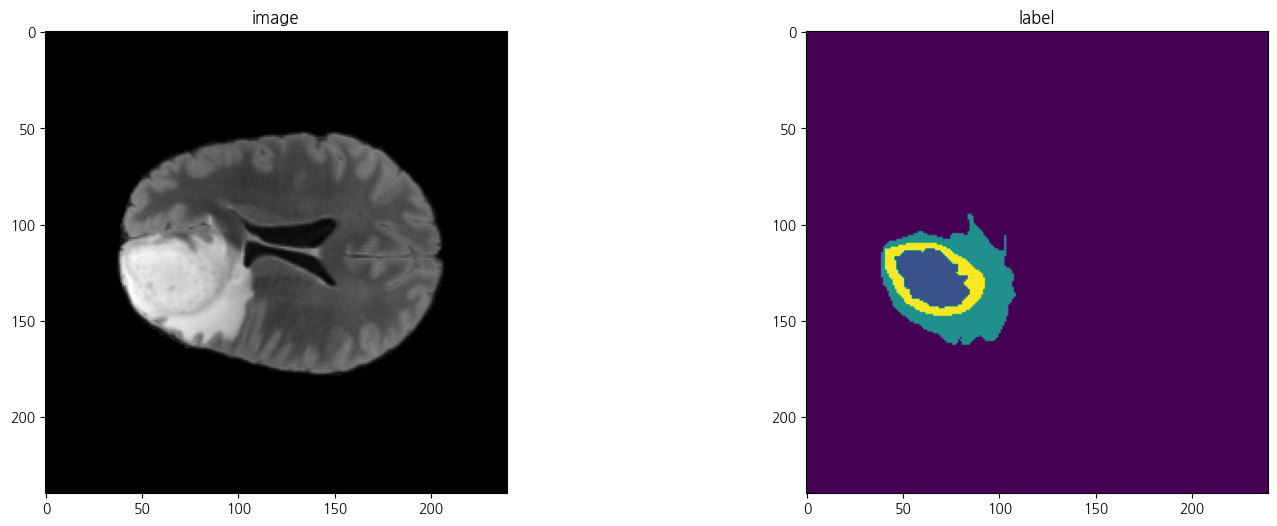

In [19]:
img_add = os.path.join(data_dir, "BraTS2021_00006/BraTS2021_00006_flair.nii.gz")
label_add = os.path.join(data_dir, "BraTS2021_00006/BraTS2021_00006_seg.nii.gz")
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
print(f"image shape: {img.shape}, label shape: {label.shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[:, :, 78], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 78])
plt.show()